# **4 Implementing a GPT model from scratch to generate text**

## **4.1 Coding an LLM architecture**

In [1]:
import torch 
import torch.nn as nn 

import tiktoken

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [3]:
class DummyTransformerBlock(nn.Module):

    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x
    

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps = 1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        return x

In [4]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
            )
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg["vocab_size"], bias = False
        )
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [5]:
tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch, dim=0)
batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [6]:
torch.manual_seed(123)

model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output Shape: ", logits.shape)
print(logits)

Output Shape:  torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## **4.2 Normalizing activations with layer normalization**

In [38]:
torch.manual_seed(123)

batch_example = torch.randn(1000,1000)
batch_example

tensor([[ 0.3374, -0.1778, -0.3035,  ..., -1.5753, -0.6813, -0.4181],
        [ 0.2573,  0.6937,  0.4207,  ..., -0.3439,  0.0665, -0.1417],
        [ 2.5754, -1.3320,  0.2282,  ...,  0.1268,  2.6668, -1.3954],
        ...,
        [-0.7404,  1.6838, -0.7466,  ...,  1.4978,  1.5824,  0.1382],
        [-0.4052, -0.3417, -1.2393,  ..., -0.8622,  0.3899, -2.1674],
        [-0.3101,  0.2659,  0.2810,  ...,  1.5808, -1.4378,  2.6974]])

In [39]:
layer = nn.Sequential(nn.Linear(1000,10), nn.ReLU())
out = layer(batch_example)
out

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.4110, 0.0000, 0.4312],
        [0.4000, 1.2636, 0.6592,  ..., 0.1944, 0.4920, 0.7376],
        [0.2260, 0.0000, 0.0310,  ..., 0.0000, 0.0000, 0.7800],
        ...,
        [0.5723, 0.2858, 0.9167,  ..., 0.0000, 1.0340, 0.7567],
        [0.4171, 0.4055, 0.0000,  ..., 0.6105, 0.1221, 0.0000],
        [0.0000, 0.5360, 0.8316,  ..., 0.0139, 0.8438, 0.1777]],
       grad_fn=<ReluBackward0>)

In [40]:
mean = out.mean(dim=-1, keepdim=True)
mean

tensor([[0.1745],
        [0.3747],
        [0.1395],
        [0.3079],
        [0.1360],
        [0.2788],
        [0.1580],
        [0.2092],
        [0.0935],
        [0.1467],
        [0.2579],
        [0.2674],
        [0.2814],
        [0.2149],
        [0.2921],
        [0.1800],
        [0.3233],
        [0.1616],
        [0.3239],
        [0.3288],
        [0.4210],
        [0.1416],
        [0.1825],
        [0.1306],
        [0.2717],
        [0.4673],
        [0.3418],
        [0.1229],
        [0.1214],
        [0.1386],
        [0.3089],
        [0.1729],
        [0.1103],
        [0.2573],
        [0.1715],
        [0.1455],
        [0.1742],
        [0.2827],
        [0.2615],
        [0.1644],
        [0.1953],
        [0.3117],
        [0.2878],
        [0.0955],
        [0.1235],
        [0.1653],
        [0.4099],
        [0.3649],
        [0.2076],
        [0.1700],
        [0.2151],
        [0.5239],
        [0.4395],
        [0.0214],
        [0.2322],
        [0

In [ ]:
var = out.var(dim=1, keepdim=True, unbiased = False)
var

tensor([[    0.0352],
        [    0.1611],
        [    0.0594],
        [    0.1372],
        [    0.0354],
        [    0.2706],
        [    0.0935],
        [    0.0478],
        [    0.0275],
        [    0.0626],
        [    0.1124],
        [    0.1237],
        [    0.1275],
        [    0.0804],
        [    0.1179],
        [    0.0438],
        [    0.1737],
        [    0.1278],
        [    0.0981],
        [    0.1362],
        [    0.1441],
        [    0.0228],
        [    0.0607],
        [    0.0311],
        [    0.1401],
        [    0.1964],
        [    0.1888],
        [    0.0891],
        [    0.0616],
        [    0.1287],
        [    0.0837],
        [    0.0776],
        [    0.0504],
        [    0.1418],
        [    0.1055],
        [    0.0334],
        [    0.0866],
        [    0.1149],
        [    0.3128],
        [    0.2432],
        [    0.0857],
        [    0.1207],
        [    0.1459],
        [    0.0361],
        [    0.0616],
        [ 

In [25]:
normed = ((out - mean) / torch.sqrt(var))
normed.var(dim=-1, keepdim = True)

tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)

In [26]:
torch.set_printoptions(sci_mode=False)

In [31]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()

        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=1, keepdim = True)
        var = x.var(dim=-1, keepdim = True, unbiased = False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

#### **Biased variance**

- In the variance calculation above, setting `unbiased=False` means using the formula `mean_formula` to compute the variance where n is the sample size (here, the number of features or columns); this formula does not include Bessel's correction (which uses `n-1` in the denominator), thus providing a biased estimate of the variance

- For LLMs, where the embedding dimension `n` is very large, the difference between using n and `n-1` is negligible

- However, GPT-2 was trained with a biased variance in the normalization layers, which is why we also adopted this setting for compatibility reasons with the pretrained weights that we will load in later chapters

- Let's now try out `LayerNorm` in practice:

In [32]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [36]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased = False)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## **4.3 Implementing a fedd forward network with GELU activations**

In [42]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

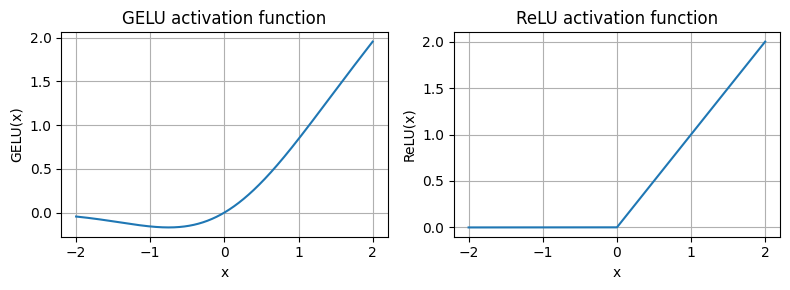

In [47]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-2, 2, 10000)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [48]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            GELU(),
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim']),
        )

    def forward(self, x):
        return self.layers(x)

In [49]:
print(GPT_CONFIG_124M["emb_dim"])

768


![](https://camo.githubusercontent.com/5b893aa5271d2f828f427f33208e4eadc1429c26c9bf4d2a1760b1384b1eeebc/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830345f636f6d707265737365642f30392e776562703f3132)

In [50]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## **4.4 Adding shortcut Connections**

![](https://camo.githubusercontent.com/b1cb95fee4a11c35cb6ce14a2399ac09875c45dc92d344713a80913e05e04c20/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830345f636f6d707265737365642f31322e776562703f313233)

In [51]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x
    
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [52]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


In [53]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


## **4.5 Connecting attention and linear layers in a transformer block**

In [55]:
from previous_chapters import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x 
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

In [57]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)

block = TransformerBlock(GPT_CONFIG_124M)

output = block(x)

In [58]:
x.shape

torch.Size([2, 4, 768])

In [59]:
output.shape

torch.Size([2, 4, 768])

## **4.6 Coding the GPT Model**

In [62]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
            )
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg["vocab_size"], bias = False
        )
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [ ]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
out = model(batch)

In [75]:
model.tok_emb.weight.shape

torch.Size([50257, 768])

In [76]:
model.out_head.weight.shape

torch.Size([50257, 768])

In [66]:
txt1, txt2, batch.shape

('Every effort moves you', 'Every day holds a', torch.Size([2, 4]))

In [68]:
out.shape

torch.Size([2, 4, 50257])

In [69]:
batch.numel()

8

In [71]:
total_params = sum(p.numel() for p in model.parameters())
total_params

163009536

In [78]:
print(f"{total_params - model.out_head.weight.numel():,}")

124,412,160


### **GPT2-medium**
```python
GPT_CONFIG_345M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 1024,         # Embedding dimension
    "n_heads": 16,          # Number of attention heads
    "n_layers": 24,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [84]:
GPT_CONFIG_345M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 1024,         # Embedding dimension
    "n_heads": 16,          # Number of attention heads
    "n_layers": 24,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [85]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_345M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.4343,  0.2477,  0.8775,  ..., -0.1311, -0.2197,  0.3829],
         [-0.2466, -0.7258, -0.3185,  ..., -0.4779, -0.4657, -0.7264],
         [ 0.1318, -0.0210, -0.0625,  ...,  0.4281,  0.3424,  0.6749],
         [-0.4247,  0.5233, -0.7132,  ...,  0.2583,  0.4504, -0.3900]],

        [[ 0.6725, -0.2065,  1.0774,  ...,  0.2958, -0.2406,  0.8569],
         [-0.2785, -0.2577, -0.4782,  ..., -0.2510,  0.1969, -0.5817],
         [-0.2633, -0.1364, -0.0722,  ...,  0.1630, -0.1352,  0.1163],
         [-0.2686,  0.6985, -0.7689,  ..., -0.2730,  0.2329, -0.5725]]],
       grad_fn=<UnsafeViewBackward0>)


In [86]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 406,212,608


In [87]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 1024])
Output layer shape: torch.Size([50257, 1024])


In [88]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 354,749,440


In [89]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 1549.58 MB


### **GPT2-Large**
```python
GPT_CONFIG_762M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 1280,         # Embedding dimension
    "n_heads": 20,          # Number of attention heads
    "n_layers": 36,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [92]:
GPT_CONFIG_762M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 1280,         # Embedding dimension
    "n_heads": 20,          # Number of attention heads
    "n_layers": 36,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [93]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_762M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.6956,  0.1888,  0.8320,  ...,  0.7104,  0.8995, -0.2434],
         [ 0.1786,  0.3723, -0.9961,  ..., -0.3018, -0.1734, -0.2609],
         [ 0.1196, -0.2275,  0.1111,  ..., -0.9261, -0.8215,  0.6183],
         [ 0.5825, -0.4191, -0.1041,  ...,  0.3299, -0.1552, -0.0180]],

        [[-0.6264,  0.5989,  0.3776,  ...,  0.7163,  0.6254, -0.6554],
         [ 0.5331,  0.0969, -0.2687,  ...,  0.0606,  0.3480,  0.1230],
         [ 0.1318, -0.7127, -0.3043,  ..., -1.0498, -0.5861,  0.4727],
         [ 0.0928, -0.1479,  0.1218,  ...,  0.0923, -0.5960,  0.2297]]],
       grad_fn=<UnsafeViewBackward0>)


In [96]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 838,220,800


In [97]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 1280])
Output layer shape: torch.Size([50257, 1280])


In [98]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 773,891,840


In [99]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 3197.56 MB


### **GPT2-XL**
```python
GPT_CONFIG_1542M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 1600,         # Embedding dimension
    "n_heads": 25,          # Number of attention heads
    "n_layers": 48,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [82]:
GPT_CONFIG_1542M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 1600,         # Embedding dimension
    "n_heads": 25,          # Number of attention heads
    "n_layers": 48,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [100]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_1542M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.4798,  0.3954,  0.0103,  ...,  0.0656, -0.0852, -0.3630],
         [ 0.2904,  0.3560, -0.6912,  ..., -0.3461,  0.1303, -0.2102],
         [ 0.0062, -0.1553,  0.4176,  ...,  0.1434,  0.5843,  0.1511],
         [-0.9854, -0.7785,  0.3243,  ...,  0.1453, -0.6150,  0.5780]],

        [[ 0.3600,  0.5446, -0.0597,  ..., -0.3957,  0.4731, -0.4495],
         [ 0.4760, -0.1653, -0.3279,  ...,  0.0303, -0.6854, -0.6495],
         [-0.0708, -0.2802,  0.3998,  ..., -0.5398,  0.1178,  0.2946],
         [-0.9527, -0.2805,  0.0268,  ...,  1.0823, -0.0229,  1.0347]]],
       grad_fn=<UnsafeViewBackward0>)


In [101]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 1,637,792,000


In [102]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 1600])
Output layer shape: torch.Size([50257, 1600])


In [103]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 1,557,380,800


In [104]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 6247.68 MB


## **4.6 Generating Text**

In [109]:
torch.argmax(torch.tensor([10,1,2,3,4,5,6,1,2,3,2,1]))

tensor(0)

In [124]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]

        probs = torch.softmax(logits, dim=-1)

        idx_next = torch.argmax(probs, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=-1)
    return idx

In [125]:
start_context = "Hello, I am model"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded: [15496, 11, 314, 716, 2746]


In [126]:
encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Our model want batch 
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded_tensor.shape: torch.Size([1, 5])


In [127]:
out = generate_text_simple(
    model, 
    idx = encoded_tensor, 
    max_new_tokens = 6, 
    context_size = 1024)

In [128]:
out

tensor([[15496,    11,   314,   716,  2746, 49760, 27385, 23818, 28193,  1440,
          4549]])

In [129]:
out.squeeze(0).tolist()

[15496, 11, 314, 716, 2746, 49760, 27385, 23818, 28193, 1440, 4549]

In [130]:
tokenizer.decode(out.squeeze(0).tolist())

'Hello, I am model composinglys cumulative Zar fouricago'